In [50]:
import os

# from MNIST_fashion.VAE_GAN import decoder

# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# Enable anomaly detection for debugging
torch.autograd.set_detect_anomaly(True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
# Hyperparameters and dataset

# Hyperparameters
batch_size = 128
learning_rate = 2e-4
num_epochs = 10
latent_dim = 100

# FashionMNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Data loading and preprocessing
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./MNIST_fashion', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./MNIST_fashion', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
# Define the VAE-GAN architecture

# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(inplace=False),
            nn.Linear(512, 256),
            nn.ReLU(inplace=False),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.model(x)
        return self.fc_mu(h), self.fc_logvar(h)

# Reparameterization
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


# Decoder (Generator)
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, 512),
            nn.ReLU(inplace=False),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [54]:
# Instantiate models
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_E = optim.Adam(encoder.parameters(), lr=learning_rate)
optimizer_G = optim.Adam(decoder.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [55]:
# Training loop

def train_vae_gan(
        encoder, decoder, discriminator,
        train_loader,
        optimizer_E, optimizer_G, optimizer_D,
        device,
        num_epochs=10,
        verbose=True,
        label="Full"
):
    vae_loss_hist = []
    gan_loss_hist = []
    d_loss_hist = []

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        discriminator.train()

        total_vae_loss = 0
        total_gan_loss = 0
        total_d_loss = 0

        for x, _ in train_loader:
            x = x.to(device)

            # VAE loss
            mu, logvar = encoder(x)
            z = reparameterize(mu, logvar)
            x_recon = decoder(z)

            recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            vae_l = recon_loss + kl_div

            optimizer_E.zero_grad()
            optimizer_G.zero_grad()
            vae_l.backward(retain_graph=True)
            optimizer_E.step()
            optimizer_G.step()

            # GAN loss
            mu, logvar = encoder(x)
            z = reparameterize(mu, logvar)
            x_recon_gan = decoder(z)

            real = torch.ones(x.size(0), 1, device=device)
            fake = torch.zeros(x.size(0), 1, device=device)

            # Discriminator step
            D_real = discriminator(x)
            D_fake = discriminator(x_recon_gan.detach())
            D_loss_real = F.binary_cross_entropy(D_real, real)
            D_loss_fake = F.binary_cross_entropy(D_fake, fake)
            D_loss = D_loss_real + D_loss_fake

            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()

            # Generator step
            G_fake = discriminator(x_recon_gan)
            G_loss = F.binary_cross_entropy(G_fake, real)

            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

            total_vae_loss += vae_l.item()
            total_gan_loss += G_loss.item()
            total_d_loss += D_loss.item()

        # Save losses
        avg_vae = total_vae_loss / len(train_loader)
        avg_gan = total_gan_loss / len(train_loader)
        avg_d = total_d_loss / len(train_loader)

        vae_loss_hist.append(avg_vae)
        gan_loss_hist.append(avg_gan)
        d_loss_hist.append(avg_d)

        if verbose:
            print(f"[{label}] Epoch [{epoch + 1}/{num_epochs}] "
                  f"VAE Loss: {avg_vae:.4f} | GAN G Loss: {avg_gan:.4f} | D Loss: {avg_d:.4f}")

    return vae_loss_hist, gan_loss_hist, d_loss_hist


In [56]:
# Class labels
sandal_label = 5
boot_label = 9


# From train dataset
# Convert targets to a NumPy array for indexing
targets_np = np.array(train_dataset.targets)

# Get indices for 'Sandal' and 'Ankle boot'
sandal_indices = np.where(targets_np == sandal_label)[0]
boot_indices = np.where(targets_np == boot_label)[0]
# Combine the indices
combined_indices = np.concatenate([sandal_indices, boot_indices])


# Creating datasets and loaders
# subset with only sandals
sandal_dataset = Subset(train_dataset, sandal_indices)
sandal_loader = DataLoader(sandal_dataset, batch_size=batch_size, shuffle=True)

# subset with only boots
boot_dataset = Subset(train_dataset, boot_indices)
boot_loader = DataLoader(boot_dataset, batch_size=batch_size, shuffle=True)

# subset with both sandals and boots
sandal_boot_dataset = Subset(train_dataset, combined_indices)
sandal_boot_loader = DataLoader(sandal_boot_dataset, batch_size=batch_size, shuffle=True)

In [57]:
vae_loss_sandal_boot, gan_loss_sandal_boot, d_loss_sandal_boot = train_vae_gan(
    encoder, decoder, discriminator,
    sandal_boot_loader,
    optimizer_E, optimizer_G, optimizer_D,
    device,
    num_epochs=num_epochs,
    verbose=True,
    label="Sandal-Boot"
)

[Sandal-Boot] Epoch [1/10] VAE Loss: 343.7928 | GAN G Loss: 1.2472 | D Loss: 0.9275
[Sandal-Boot] Epoch [2/10] VAE Loss: 257.0038 | GAN G Loss: 1.3904 | D Loss: 0.8962
[Sandal-Boot] Epoch [3/10] VAE Loss: 242.0573 | GAN G Loss: 1.4683 | D Loss: 0.6734
[Sandal-Boot] Epoch [4/10] VAE Loss: 237.8776 | GAN G Loss: 1.9115 | D Loss: 0.4920
[Sandal-Boot] Epoch [5/10] VAE Loss: 235.5914 | GAN G Loss: 2.2742 | D Loss: 0.4190
[Sandal-Boot] Epoch [6/10] VAE Loss: 234.3687 | GAN G Loss: 2.5802 | D Loss: 0.3331
[Sandal-Boot] Epoch [7/10] VAE Loss: 232.6981 | GAN G Loss: 2.6765 | D Loss: 0.3871
[Sandal-Boot] Epoch [8/10] VAE Loss: 231.2846 | GAN G Loss: 2.6842 | D Loss: 0.3873
[Sandal-Boot] Epoch [9/10] VAE Loss: 229.9109 | GAN G Loss: 2.7864 | D Loss: 0.3593
[Sandal-Boot] Epoch [10/10] VAE Loss: 228.6781 | GAN G Loss: 2.8412 | D Loss: 0.4041


In [58]:
# Put encoder in eval mode
encoder.eval()

all_z = []
all_labels = []

with torch.no_grad():
    for x, _ in sandal_boot_loader:
        x = x.to(device)
        mu, logvar = encoder(x)
        z = reparameterize(mu, logvar)
        all_z.append(z.cpu())
        all_labels.append(_.cpu())

# Stack all embeddings and labels
z_concat = torch.cat(all_z).numpy() # fake data with labels for both classes
labels_concat = torch.cat(all_labels).numpy()

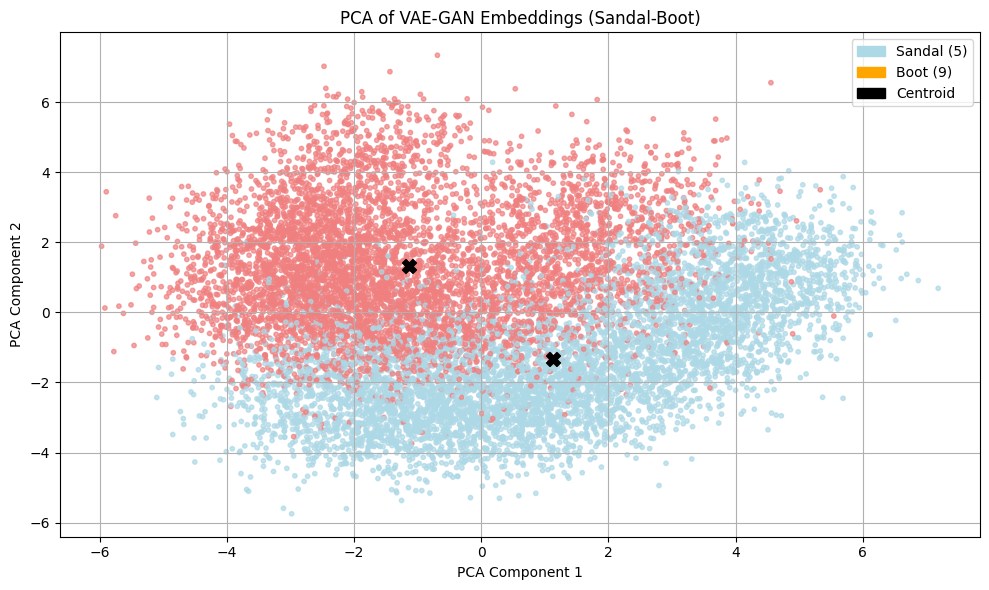

In [59]:
# perform PCA on the embeddings to visualise

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(z_concat)

# Assuming x_pca.shape = (n_samples, 2) and labels_concat.shape = (n_samples,)
centroids = []
for label in np.unique(labels_concat):
    indices = (labels_concat == label)
    centroid = x_pca[indices].mean(axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Map labels to custom colors
custom_colors = ['lightcoral' if lbl == 5 else 'lightblue' if lbl == 9 else 'lightgray' for lbl in labels_concat]

# Create figure
plt.figure(figsize=(10, 6))

# Scatter with custom colors
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=custom_colors, s=10, alpha=0.7)

# Centroids in dark red and dark blue
plt.scatter(centroids[0, 0], centroids[0, 1], c='black', s=100, marker='X', label='Centroid - Sandal (5)')
plt.scatter(centroids[1, 0], centroids[1, 1], c='black', s=100, marker='X', label='Centroid - Boot (9)')

# Title and labels
plt.title('PCA of VAE-GAN Embeddings (Sandal-Boot)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Custom legend
legend_handles = [
    mpatches.Patch(color='lightblue', label='Sandal (5)'),
    mpatches.Patch(color='orange', label='Boot (9)'),
    mpatches.Patch(color='black', label='Centroid')
]
plt.legend(handles=legend_handles)

# Grid and layout
plt.grid(True)
plt.tight_layout()
plt.show()


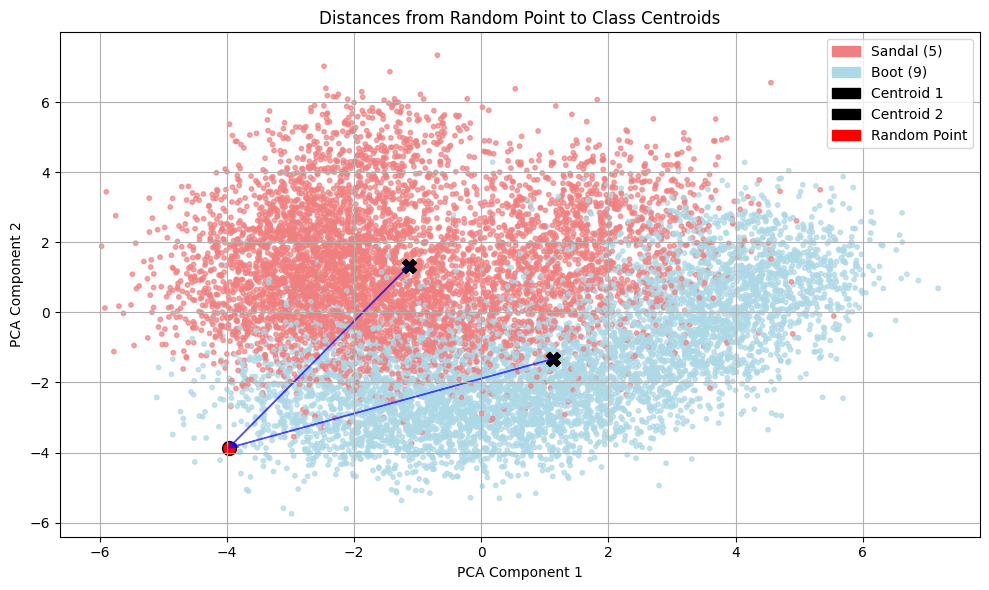

In [60]:
# For a random point how to evaluate weight.
# Select a random point from x_pca
random_point = np.random.uniform(-6, 6, size=2)
latent_rep_random_point = pca.inverse_transform(random_point)
latent_rep_centroids = pca.inverse_transform(centroids) #2x100


# Compute Euclidean distances to each centroid
distances = np.linalg.norm(latent_rep_centroids - latent_rep_random_point, axis=1)

weighted = 1 - (distances/sum(distances))



import matplotlib.patches as mpatches

# Create figure
plt.figure(figsize=(10, 6))

# Custom colors for classes 5 and 9
custom_colors = ['lightcoral' if l == 5 else 'lightblue' if l == 9 else 'lightgray' for l in labels_concat]

# Scatter plot with custom colors
scatter = plt.scatter(
    x_pca[:, 0], x_pca[:, 1],
    c=custom_colors, s=10, alpha=0.7
)

# Overlay centroids and random point
plt.scatter(centroids[0, 0], centroids[0, 1], c='black', s=100, marker='X', label='Centroid - Sandal (5)')
plt.scatter(centroids[1, 0], centroids[1, 1], c='black', s=100, marker='X', label='Centroid - Boot (9)')
plt.scatter(random_point[0], random_point[1], c='red', s=100, marker='o', edgecolors='black', label='Random Point')

# Arrows from centroids to random point
for i in range(len(centroids)):
    plt.arrow(
        centroids[i, 0], centroids[i, 1],
        random_point[0] - centroids[i, 0],
        random_point[1] - centroids[i, 1],
        color='blue', width=0.01, head_width=0.1, alpha=0.6, length_includes_head=True
    )

# Custom legend
legend_handles = [
    mpatches.Patch(color='lightcoral', label='Sandal (5)'),
    mpatches.Patch(color='lightblue', label='Boot (9)'),
    mpatches.Patch(color='black', label='Centroid 1'),
    mpatches.Patch(color='black', label='Centroid 2'),
    mpatches.Patch(color='red', label='Random Point')
]
plt.legend(handles=legend_handles)

# Axis titles and formatting
plt.title('Distances from Random Point to Class Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
# From test dataset

test_targets_np = np.array(test_dataset.targets)

sandal_indices_test = np.where(test_targets_np == sandal_label)[0]
boot_indices_test = np.where(test_targets_np == boot_label)[0]
combined_test_indices = np.concatenate([sandal_indices_test, boot_indices_test])


# Creating datasets and loaders
sandal_boot_test_dataset = Subset(test_dataset, combined_test_indices)
sandal_boot_test_loader = DataLoader(sandal_boot_test_dataset, batch_size=batch_size, shuffle=True)

# subset with only boots
sandal_dataset_test = Subset(test_dataset, sandal_indices)
sandal_loader_test = DataLoader(sandal_boot_dataset, batch_size=batch_size, shuffle=True)

# subset with only boots
boot_dataset_test = Subset(test_dataset, boot_indices)
boot_loader_test = DataLoader(sandal_boot_dataset, batch_size=batch_size, shuffle=True)

In [62]:
# Put encoder in eval mode
encoder.eval()

all_z = []
all_labels = []

with torch.no_grad():
    for x, _ in sandal_boot_test_loader:
        x = x.to(device)
        mu, logvar = encoder(x)
        z = reparameterize(mu, logvar)
        all_z.append(z.cpu())
        all_labels.append(_.cpu())

# Stack all embeddings and labels
z_concat_test = torch.cat(all_z).numpy() # fake data with labels for both classes
labels_concat_test = torch.cat(all_labels).numpy()

In [63]:
z_concat_test.shape

(2000, 100)

In [64]:
# given a data point , evaluate weight  in the PCA space and normalized it.
from sklearn.metrics import pairwise_distances

def weights(latent_data_set, latent_rep_centroids):
    """
    latent_data_set (N, 100) ; (# data points x # latent space dimension))
    latent_rep_centroids (2, 100) ; ( # classes x latent space dimension))
    """
    latent_rep_centroids = pca.inverse_transform(centroids) #2x100
    # Compute Euclidean distances to each centroid
    distances = pairwise_distances(latent_data_set, latent_rep_centroids, metric='euclidean')
    # distances: shape (N, 2), where N = number of samples
    row_sums = distances.sum(axis=1, keepdims=True) + 1e-8  # avoid divide-by-zero
    normalized_distances = distances / row_sums  # shape: (N, 2)
    weighted = 1 - normalized_distances # shape: (N, 2)
    return weighted
weights = weights(z_concat_test, latent_rep_centroids)

## Training discriminators

In [65]:
# Instantiate two discriminators
sandal_discriminator = Discriminator().to(device)
boot_discriminator = Discriminator().to(device)

# Separate optimizers
optimizer_D_sandal = optim.Adam(sandal_discriminator.parameters(), lr=learning_rate)
optimizer_D_boot = optim.Adam(boot_discriminator.parameters(), lr=learning_rate)

In [66]:
def train_discriminator_on_subset(
    discriminator, data_loader, encoder, decoder,
    optimizer, device, num_epochs=5, label='Subset'
):
    discriminator.train()
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        for x, _ in data_loader:
            x = x.to(device)
            real = torch.ones(x.size(0), 1, device=device)
            fake = torch.zeros(x.size(0), 1, device=device)

            # Generate fake images
            with torch.no_grad():
                mu, logvar = encoder(x)
                z = reparameterize(mu, logvar)
                x_fake = decoder(z)

            # Discriminator forward passes
            D_real = discriminator(x)
            D_fake = discriminator(x_fake.detach())

            # Losses
            loss_real = F.binary_cross_entropy(D_real, real)
            loss_fake = F.binary_cross_entropy(D_fake, fake)
            loss = loss_real + loss_fake

            # Backprop and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        loss_history.append(avg_loss)
        print(f"[{label}] Epoch [{epoch + 1}/{num_epochs}] - Discriminator Loss: {avg_loss:.4f}")

    return loss_history

In [67]:
# Train sandal discriminator
train_discriminator_on_subset(
    discriminator=sandal_discriminator,
    data_loader=sandal_loader,
    encoder=encoder,
    decoder=decoder,
    optimizer=optimizer_D_sandal,
    device=device,
    num_epochs=10,
    label="Sandal"
)

# Train boot discriminator
train_discriminator_on_subset(
    discriminator=boot_discriminator,
    data_loader=boot_loader,
    encoder=encoder,
    decoder=decoder,
    optimizer=optimizer_D_boot,
    device=device,
    num_epochs=10,
    label="Boot"
)

[Sandal] Epoch [1/10] - Discriminator Loss: 1.1579
[Sandal] Epoch [2/10] - Discriminator Loss: 0.5040
[Sandal] Epoch [3/10] - Discriminator Loss: 0.1821
[Sandal] Epoch [4/10] - Discriminator Loss: 0.0899
[Sandal] Epoch [5/10] - Discriminator Loss: 0.0510
[Sandal] Epoch [6/10] - Discriminator Loss: 0.0321
[Sandal] Epoch [7/10] - Discriminator Loss: 0.0222
[Sandal] Epoch [8/10] - Discriminator Loss: 0.0144
[Sandal] Epoch [9/10] - Discriminator Loss: 0.0105
[Sandal] Epoch [10/10] - Discriminator Loss: 0.0079
[Boot] Epoch [1/10] - Discriminator Loss: 1.2043
[Boot] Epoch [2/10] - Discriminator Loss: 0.7194
[Boot] Epoch [3/10] - Discriminator Loss: 0.3967
[Boot] Epoch [4/10] - Discriminator Loss: 0.2019
[Boot] Epoch [5/10] - Discriminator Loss: 0.1158
[Boot] Epoch [6/10] - Discriminator Loss: 0.0734
[Boot] Epoch [7/10] - Discriminator Loss: 0.0510
[Boot] Epoch [8/10] - Discriminator Loss: 0.0368
[Boot] Epoch [9/10] - Discriminator Loss: 0.0277
[Boot] Epoch [10/10] - Discriminator Loss: 0.019

[1.2042797765833266,
 0.719415509954412,
 0.3967306052750729,
 0.2018589380573719,
 0.115836186770429,
 0.07341832310912456,
 0.050970324453838325,
 0.036828453434591596,
 0.02766966534421799,
 0.01948745637894311]

In [72]:
def evaluate_multiple_discriminators(discriminators, encoder, decoder, test_loader, latent_dim, device, weights_array, label=""):
    """
    Evaluate multiple discriminators (per class) with per-sample weights.

    Args:
        discriminators (dict): {class_idx: discriminator_model}
        encoder (nn.Module): encoder module
        decoder (nn.Module): decoder module
        test_loader (DataLoader): test data loader
        latent_dim (int): latent space dimensionality
        device (torch.device): CPU or CUDA
        weights_array (np.ndarray): shape (N_total, C), per-sample weights for C discriminators
        label (str): label prefix for plots
    """
    class_indices = list(discriminators.keys())
    C = len(class_indices)

    for disc in discriminators.values():
        disc.eval()

    real_scores_all = []
    fake_scores_all = []
    start_idx = 0  # to track position in weights_array

    with torch.no_grad():
        for x, y in test_loader:
            B = x.size(0)  # batch size
            x = x.to(device)

            # Slice the weights for this batch
            batch_weights = torch.tensor(weights_array[start_idx:start_idx + B], dtype=torch.float32, device=device)  # shape (B, C)

            # Get real scores from each class-specific discriminator
            disc_outputs_real = []
            for cls in class_indices:
                scores = discriminators[cls](x).squeeze()  # shape (B,)
                scores = (scores >= 0.5).to(torch.int)
                disc_outputs_real.append(scores.unsqueeze(1))  # shape (B, 1)

            # Stack and compute weighted sum
            real_stacked = torch.cat(disc_outputs_real, dim=1)  # shape (B, C)
            real_weighted = (real_stacked * batch_weights).sum(dim=1)  # shape (B,)
            real_scores_all.append(real_weighted.cpu().numpy())



            # Generate fake images
            mu, logvar = encoder(x)
            z = reparameterize(mu, logvar)
            x_fake = decoder(z)

            # Get fake scores
            disc_outputs_fake = []
            for cls in class_indices:
                scores = discriminators[cls](x_fake).squeeze()
                scores = (scores >= 0.5).to(torch.int)
                disc_outputs_fake.append(scores.unsqueeze(1))

            fake_stacked = torch.cat(disc_outputs_fake, dim=1)  # shape (B, C)
            fake_weighted = (fake_stacked * batch_weights).sum(dim=1)  # shape (B,)
            fake_scores_all.append(fake_weighted.cpu().numpy())

            start_idx += B  # advance index

        # Compute average weighted contribution per class
    per_class_scores = {cls: [] for cls in class_indices}
    per_class_weights = {cls: [] for cls in class_indices}
    start_idx = 0  # reset for new pass

    with torch.no_grad():
        for x, _ in test_loader:
            B = x.size(0)
            x = x.to(device)
            batch_weights = torch.tensor(weights_array[start_idx:start_idx + B], dtype=torch.float32, device=device)

            for i, cls in enumerate(class_indices):
                scores = discriminators[cls](x).squeeze()
                scores = (scores >= 0.5)
                per_class_scores[cls].append(scores.cpu().numpy())
                per_class_weights[cls].append(batch_weights[:, i].cpu().numpy())

            start_idx += B

    avg_weighted_contributions = {}
    for cls in class_indices:
        scores = np.concatenate(per_class_scores[cls])
        scores = (scores >= 0.5)
        weights = np.concatenate(per_class_weights[cls])
        avg_weighted_contributions[cls] = np.mean(scores * weights)

    # Plot bar chart of weighted contributions
    class_names = {5: "Sandal", 9: "Ankle boot"}  # Extend if needed
    labels = [class_names.get(cls, f"Class {cls}") for cls in class_indices]
    values = [avg_weighted_contributions[cls] for cls in class_indices]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=['coral', 'blue'])
    plt.ylabel("Weighted Discriminator Contribution (Real)")
    plt.title(f"{label} - Real Image: Weighted Class Contributions")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Compute means
    real_mean = np.mean(np.concatenate(real_scores_all))
    fake_mean = np.mean(np.concatenate(fake_scores_all))

    print(f"[{label}] Weighted Real Image Score Mean: {real_mean:.4f}")
    print(f"[{label}] Weighted Fake Image Score Mean: {fake_mean:.4f}")

    # Optional: visualize
    plt.figure(figsize=(6, 4))
    plt.hist(np.concatenate(real_scores_all), bins=40, alpha=0.6, label='Real', color='green')
    plt.hist(np.concatenate(fake_scores_all), bins=40, alpha=0.6, label='Fake', color='red')
    plt.title(f"{label} Per-sample Weighted Discriminator Scores")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


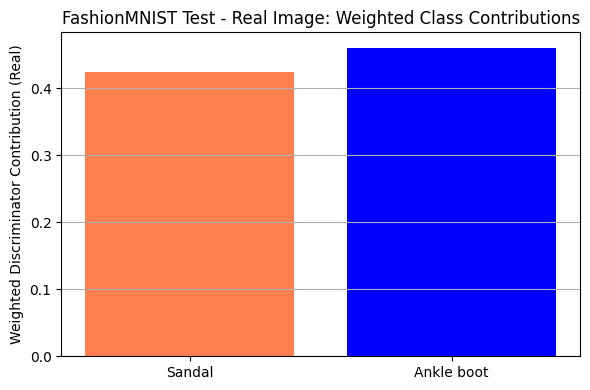

[FashionMNIST Test] Weighted Real Image Score Mean: 0.8851
[FashionMNIST Test] Weighted Fake Image Score Mean: 0.0238


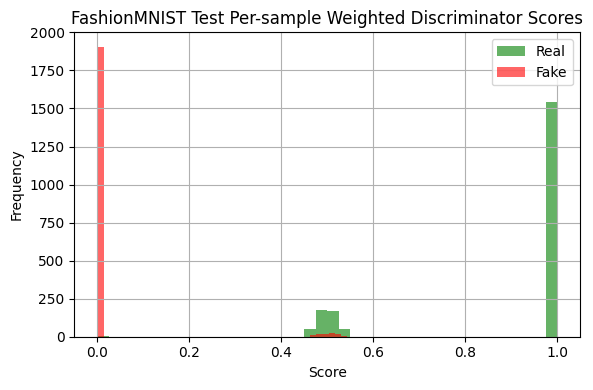

In [73]:
# 1. Create your discriminators dictionary
discriminators = {
    5: sandal_discriminator,      # class index 5
    9: boot_discriminator         # class index 9
}

# 3. Evaluate
evaluate_multiple_discriminators(
    discriminators=discriminators,
    encoder=encoder,
    decoder=decoder,
    test_loader=sandal_boot_test_loader,
    latent_dim=latent_dim,
    device=device,
    weights_array=weights,
    label="FashionMNIST Test"
)
